In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import rsciio.digitalmicrograph as dm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
from scipy import signal
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
class NNTrainer:
    def __init__(self, x_data, y_data, edge_onset):
        self.X = x_data.clone() # input data [n_E, 2]
        self.y = y_data.clone() # output data [n_E, n_spectrum]
        self.edge_onset = edge_onset

        self.device = torch.device('cpu') # torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = EELSBackgroundNet().to(self.device)

        # Extrema of the in/outputs
        self.min_x1 = torch.min(self.X[:, 0]).item()
        self.max_x1 = torch.max(self.X[:, 0]).item()
        self.min_x2 = torch.min(self.X[:, 1]).item()
        self.max_x2 = torch.max(self.X[:, 1]).item()
        self.min_y = torch.min(self.y).item()
        self.max_y = torch.max(self.y).item()

        # Normalization of training data to (0,1)
        self.X[:, 0] = (self.X[:, 0] - self.min_x1) / (self.max_x1 - self.min_x1) 
        self.edge_onset_normalized = (self.edge_onset - self.min_x1) / (self.max_x1 - self.min_x1)
        self.X[:, 1] = (self.X[:, 1] - self.min_x2) / (self.max_x2 - self.min_x2) 
        self.y = (self.y - self.min_y) / (self.max_y - self.min_y) 

        self.evaluation_loss = None

    def loss_function(self, x, y_true, y_pred):
        """ 
        Loss function.
        Calculate the mean squared error for all values x less than the edge onset
        
        TODO:
            - Make robust for case when entire batch is below edge onset energy
            - Add optional regularization/physics
            - Account for 
        """

        
        mask = x[:, 0] < self.edge_onset_normalized
        if mask.sum() != 0:
            y_true = y_true[mask]
            y_pred = y_pred[mask]
            mse_loss = nn.MSELoss()(y_pred, y_true)
        else:
            mse_loss = 0

        total_loss =  mse_loss
        return total_loss


    def train(self, epochs=200, lr=0.001):
        """
        Training method for the neural network.

        
        """
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        dataset = TensorDataset(self.X, self.y)

        dataloader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True 
                                if self.device.type == "cuda" else False)

        # Main training loop
        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            start_time = time.time()

            for inputs, targets in dataloader:
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = self.loss_function(inputs, outputs.squeeze().clone(), targets.clone())
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
            
            if not (epoch+1) % 10 or epoch == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    def evaluate_model(self, x_eval, y_eval, effective_exponent_window_size = 5):
        '''
        Method for evaluation of the model.
        Below E_edge the model is evaluated verbatim. 
        
        In the effective_exponent_window slice the effective exponent is calculated.
        The mean of these exponents is used to extrapolate a power law from the edge onset further.

        I(E) = C * E^-r => ln(I) = ln(C) - r*ln(E) 
        with ln(C) = ln(I(E_edge)) + r*ln(E_edge)

        parameters:
        ----------
        x_eval : torch.Tensor shape (n_spectrum, n_energy, 2)
            Evaluation data.
        y_eval : torch.Tensor shape (n_spectrum, n_energy)
            Evaluation labels.
        effective_exponent_window_size : int
            number of points to use for the effective exponent calculation.
        '''
        x_eval = x_eval.clone() 

        self.evaluation_loss = np.zeros(x_eval.shape[0])

        edge_onset_index =  np.abs(x_eval[0,:,0] - self.edge_onset).argmin()
        effective_exponent_window = slice(edge_onset_index-effective_exponent_window_size, edge_onset_index)

        n_spectrum, n_energy, _ = x_eval.shape

        outputs = torch.zeros((n_spectrum, n_energy), dtype=torch.float32)

        for i in range(n_spectrum):
            x_eval_i = x_eval[i, :, :].reshape(-1, 2)
            energy_unnorm = x_eval[i, :, 0].clone()  # shape: (n_energy,)

            # Normalization of evaluation values
            x_eval_i[:, 0] = (x_eval_i[:, 0] - self.min_x1) / (self.max_x1 - self.min_x1)
            x_eval_i[:, 1] = (x_eval_i[:, 1] - self.min_x2) / (self.max_x2 - self.min_x2)
            x_eval_i = x_eval_i.to(self.device)
            
            
            x_eval_i.requires_grad_(True)
            self.model.eval()
            outputs_normalized = self.model(x_eval_i)
            outputs_unnormalized = outputs_normalized * (self.max_y - self.min_y) + self.min_y
            
            # Compute gradients for effective exponent region
            gradient = torch.autograd.grad(outputs_normalized.sum(), x_eval_i, retain_graph=True)[0]
            grad_x1 = gradient[effective_exponent_window, 0].detach().numpy() #  = d(lnI)'/dE'
            grad_x1 = -energy_unnorm[effective_exponent_window].numpy() *grad_x1*(self.max_y-self.min_y )/(self.max_x1-self.min_x1) # = dlnI/dE
            
            effective_exponent = np.mean(grad_x1)
            
            # Compute power law constants
            log_C = outputs_unnormalized[edge_onset_index].detach() + effective_exponent * np.log(self.edge_onset)
            energy_for_log = energy_unnorm[edge_onset_index:]
            power_law_log_I = log_C - effective_exponent * torch.log(energy_for_log)

            # Store values
            outputs[i,edge_onset_index:] += power_law_log_I
            outputs[i, :edge_onset_index] += outputs_unnormalized[:edge_onset_index].squeeze()
            self.evaluation_loss[i] = self.loss_function(
                                                x_eval_i[:edge_onset_index],
                                                torch.tensor(y_eval[i, :edge_onset_index]),
                                                outputs_unnormalized[:edge_onset_index].squeeze().clone()
                                            ).item()
            self.outputs = outputs
        return outputs        


class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16,  4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
    def forward(self, x):
        return self.model(x)

In the evaluation, calculating the effective exponents seems weird, but the math comes from conversion between normalized values which the model uses to unnormalized values that we want. We first define the effective exponent as follows:

$$
-r := \frac{\partial\ln{I}}{\partial\ln{E}}
$$

And the normalization operations are:

$$
\ln(I)' = \frac{\ln(I)-\text{min}(\ln(I))}{\text{max}(\ln(I))-\text{min}(\ln(I))} ~~~~| ~~~~ E' = \frac{E-\text{min}(E)}{\text{max}(E)-\text{min}(E)}
$$

The output we get from the autogradient $\texttt{torch.autograd.grad}$ is $\frac{\partial\ln{I'}}{\partial E'}$. Doing some math gives us:

$$
-r = E\frac{c_I}{c_E}\frac{\partial\ln{I'}}{\partial E'}
$$

with c_x equal to the difference between max an min

In [ ]:
class NNparameterization:

    def __init__(self):
        self.spatial_axis = None
        self.energy_axis = None
        self.intensity_data = None

        self.clusters = None
        self.clustered_spectra_mean = None
        self.clustered_spectra_std = None

        self.total_integrated_intensity = None

        self.y = None
        self.X_mc = None

        self.X_eval = None

        self.background = None

    def read_dm3(self, path, SI = False):
        '''Read EELS data from a DM3 file

        TODO:
            - Make it correctly read DM4 files
            - Automatically read and convert spectral images to line scans
        '''
        raw_data = dm.file_reader(path)
        if SI:
            spectral_image = raw_data[0]['data'][:,:] #shape [n_energy, n_y, n_x]

            energy_loss_md = raw_data[0]['axes'][0]
            offset, scale, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
            self.energy_axis = np.linspace(offset, offset + scale * (size - 1), size)

            spatial_y_md = raw_data[0]['axes'][1]
            offset, scale, self.size_y = spatial_y_md['offset'], spatial_y_md['scale'], spatial_y_md['size']
            spatial_y_axis = np.linspace(offset, offset + scale * (self.size_y - 1), self.size_y)

            spatial_x_md = raw_data[0]['axes'][2]
            offset, scale, self.size_x = spatial_x_md['offset'], spatial_x_md['scale'], spatial_x_md['size']
            spatial_x_axis = np.linspace(offset, offset + scale * (self.size_x - 1), self.size_x)

            self.spatial_axis = np.linspace(offset, offset + scale * (self.size_x*self.size_y - 1), self.size_x*self.size_y)

            self.intensity_data = spectral_image.reshape(-1, self.size_x*self.size_y).T # shape [n_y*n_x, n_E]
        
        else:
            # Intensity Data
            self.intensity_data = raw_data[0]['data'][:,:] # shape [n_spectrum, n_E]

            # Read metadata and convert to numpy for energy loss exis
            energy_loss_md = raw_data[0]['axes'][1]
            offset, scale, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
            self.energy_axis = np.linspace(offset, offset + scale * (size - 1), size)

            spatial_md = raw_data[0]['axes'][0]
            offset, scale, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
            self.spatial_axis = np.linspace(offset, offset + scale * (size - 1), size)
    
    def align_data(self, reference_spectrum_index = 0):
        '''
        Aligns the core loss data by cross-correlating the data with the reference spectrum.
        Shift all spectra by  $argmax(I_ref*I_i)$
        Window data such that all spectra have the same range.
        '''
        shifts = []
        reference_spectrum = self.intensity_data[reference_spectrum_index]
        for i, x in enumerate(self.intensity_data):
            cross_correlate = signal.correlate(x, reference_spectrum, mode='full')
            shift = len(x) - np.argmax(cross_correlate)
            self.intensity_data[i] = np.roll(x, shift)
            shifts.append(shift)

        #window data such that all spectra starts/ends at the same energy loss
        self.window_data(lower = self.energy_axis[max(shifts)], 
                         higher = self.energy_axis[min(shifts)] if min(shifts)<0 else  1e6)
                
    def window_data(self, lower, higher):
        '''
        Windows the core loss data to a specific energy loss range
        '''
        window = (self.energy_axis<higher)&(self.energy_axis>lower)
        self.intensity_data = self.intensity_data[:,window]
        self.energy_axis = self.energy_axis[window]

    def plot_spectra(self, spectra_indices=None):
        '''
        Plots the core loss data for the specified spectra indices, or all spectra if none are specified.
        '''
        plt.figure(figsize=(10, 6))
        if spectra_indices is None:
            spectra_indices = range(self.intensity_data.shape[0])
            plt.imshow(self.intensity_data, aspect='auto', extent=(self.energy_axis[0], self.energy_axis[-1], 
                                                                   self.spatial_axis[0], self.spatial_axis[-1]), cmap='plasma')
        else:
            for i in spectra_indices:
                plt.plot(self.energy_axis, self.intensity_data[i], label=f'Spectrum {i}')
        plt.xlabel('Energy Loss (eV)')
        plt.ylabel('Intensity (a.u.)')
        plt.title('Core Loss Spectra')
        plt.legend()
        plt.show()

    def cluster_data(self, n_clusters):
        '''
        Clusters the spectra based on their total integrated intensity using KMeans clustering.
        The total integrated intesnity is the sum of the intensity along the energy axis. 
        The covariance of the spectra in each cluster is calculated

        TODO:
            -Add option to use other values for clustering
        '''
        
        self.total_integrated_intensity = np.sum(self.intensity_data, axis=1) # shape [n_spectrum]

        kmeans = KMeans(n_clusters=n_clusters)
        self.clusters = kmeans.fit_predict(self.total_integrated_intensity.reshape(-1, 1))   # shape [n_spectrum]

        self.clustered_spectra_mean = np.zeros((len(self.energy_axis), n_clusters))     # shape [n_E, n_clusters]
        self.clustered_spectra_cov = np.zeros((len(self.energy_axis), len(self.energy_axis), n_clusters))   # shape [n_E, n_E, n_clusters]
        self.clustered_spectra_centers = kmeans.cluster_centers_    # shape [n_clusters]

        for i in range(n_clusters):
            self.clustered_spectra_mean[:, i] = np.mean(self.intensity_data[:][self.clusters == i], axis=0)
            self.clustered_spectra_cov[:, :, i] = np.cov(self.intensity_data[:][self.clusters == i].T) 

    def prepare_X_mc_data(self):
        '''
        Prepare the X data for the Monte Carlo Replicas. 
        X_mc is the input data for the neural network, which is the same for all replicas.


        TODO:
            - Add option to use TII for actual spectra instead of cluster centers        
        '''
        
        num_energy_loss, num_clusters = self.clustered_spectra_mean.shape
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_clusters, -1)# shape [n_clusters, n_E]

        clustered_spectra_centers = torch.Tensor(self.clustered_spectra_centers).squeeze()  # Remove extra dimensions if any
        clustered_spectra_centers_expanded = torch.log(clustered_spectra_centers.unsqueeze(1).expand(-1, num_energy_loss))  # shape [num_clusters, n_E]

        X_mc = torch.stack([
            energy_axis_expanded, 
            clustered_spectra_centers_expanded
        ], dim=2)

        self.X_mc = X_mc.reshape(-1, 2) # shape [n_cluster*n_E, 2]

    def prepare_X_mc_data_tii(self, tii):
        num_energy_loss, num_clusters = self.clustered_spectra_mean.shape
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_clusters, -1)# shape [n_clusters, n_E]

        tii_tensor = torch.Tensor(tii)  # Remove extra dimensions if any
        tii_expanded = torch.log(tii_tensor.unsqueeze(1).expand(-1, num_energy_loss))  # shape [num_clusters, n_E]

        X_mc = torch.stack([
            energy_axis_expanded, 
            tii_expanded
        ], dim=2)

        self.X_mc = X_mc.reshape(-1, 2) # shape [n_cluster*n_E, 2]

    def prepare_X_eval_data(self):
        '''
        Prepare the X data for the evaluation of the neural network.

        '''
        num_spectra, num_energy_loss = self.intensity_data.shape

        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_spectra, -1)
        total_integrated_intensity_expanded = torch.log(torch.Tensor(self.total_integrated_intensity).unsqueeze(1).expand(-1, num_energy_loss))

        self.X_eval = torch.stack([
            energy_axis_expanded, 
            total_integrated_intensity_expanded
        ], dim=2)


    def train_MC_replica_consecutive(self, n_mc_replicas,epochs, edge_onset = 0):
        '''
        Train the Monte Carlo replicas using the neural network consecutively.
        '''
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1])) # shape [n_mc_replicas, n_spectrum, n_E]
        self.evaluation_loss = np.zeros((n_mc_replicas, self.intensity_data.shape[0])) # shape [n_mc_replicas, n_spectrum]
        for i in range(n_mc_replicas):
            print(f'Starting Replica {i}')
            mc_replica = np.zeros_like(self.clustered_spectra_mean)
            for cluster_id in range(mc_replica.shape[1]):
                mc_replica[:,cluster_id] = np.log(np.random.multivariate_normal(
                                                    self.clustered_spectra_mean[:,cluster_id],
                                                    self.clustered_spectra_cov[:,:,cluster_id])) # shape [n_E, n_clusters]
            # tii = np.sum(mc_replica, axis=0) # shape [n_clusters]
            # self.prepare_X_mc_data_tii(tii)
            # plt.plot(self.energy_axis, mc_replica)
            y = torch.Tensor(mc_replica.T).reshape(-1) # shape [n_clusters*n_E]
            print(y.shape, self.X_mc.shape)

            NN_object = NNTrainer(self.X_mc, y, edge_onset)
            NN_object.train(epochs=epochs)

            self.background[i] = np.exp(NN_object.evaluate_model(self.X_eval, self.intensity_data).squeeze(-1).detach().numpy()) #shape [n_spectrum, n_E]
            self.evaluation_loss[i] = NN_object.evaluation_loss

    def train_MC_replica_parallel(self, n_mc_replicas, edge_onset = 0):
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1]))

        def run(i):
            mc_sample = np.random.normal(self.clustered_spectra_mean, self.clustered_spectra_std)
            if np.any(mc_sample <= 0):
                print(f"Warning in replica {i}: non-positive values")
            mc_replica = np.log(mc_sample)
            y = torch.tensor(mc_replica.T.astype(np.float32)).reshape(-1)

            NN_object = NNTrainer(self.X_mc, y, edge_onset)
            NN_object.train()
            background_i = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1))
            return i, background_i

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust worker count as needed
            futures = [executor.submit(run, i) for i in range(n_mc_replicas)]

            for future in as_completed(futures):
                i, result = future.result()
                self.background[i] = result

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bartv\AppData\Local\Temp\ipykernel_3716\2369182660.py:1: SyntaxWarning: invalid escape sequence '\D'
  path_to_data = "..\Data\TaSe2-TaS2-SI.dm3"


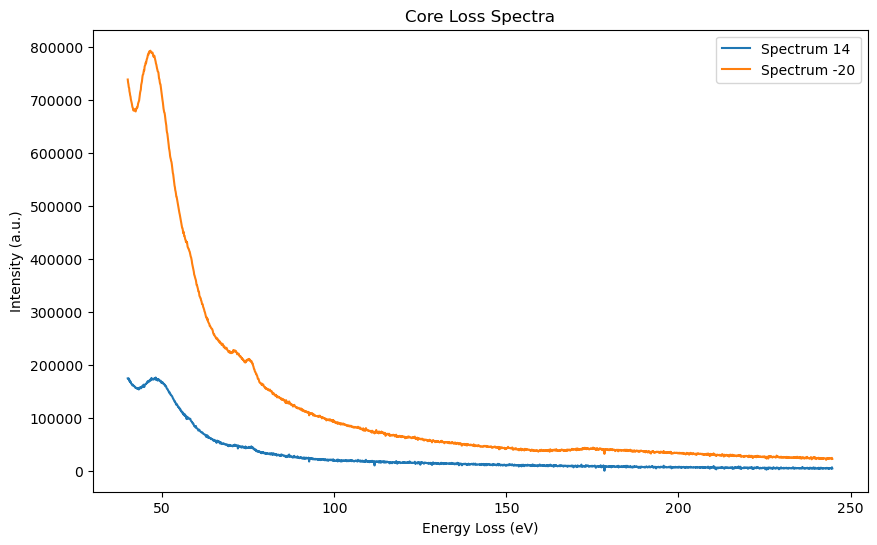

C:\Users\bartv\AppData\Local\Temp\ipykernel_3716\58879536.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


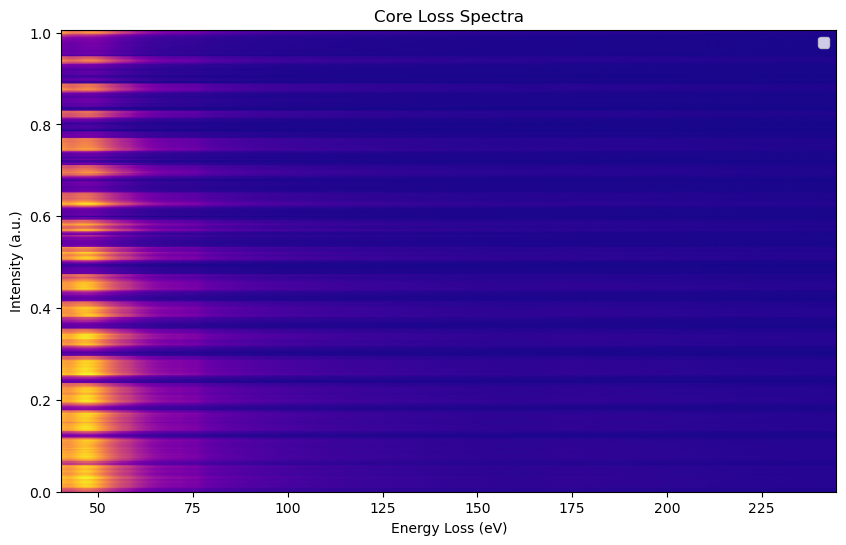

In [5]:
path_to_data = "..\Data\TaSe2-TaS2-SI.dm3"

objectNN = NNparameterization()
objectNN.read_dm3(path_to_data, SI = True)
objectNN.plot_spectra([14,-20])
objectNN.align_data()
objectNN.plot_spectra()



In [6]:
objectNN.window_data(lower=150, higher = 180)
# objectNN.plot_spectra(spectra_indices=[1,60,120])
objectNN.cluster_data(n_clusters=5)
objectNN.prepare_X_mc_data()
objectNN.prepare_X_eval_data()
objectNN.train_MC_replica_consecutive(n_mc_replicas=10, edge_onset=165, epochs = 100)

c:\Users\bartv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\bartv\AppData\Local\Temp\ipykernel_3716\58879536.py:193: RuntimeWarning: invalid value encountered in log
  mc_replica[:,cluster_id] = np.log(np.random.multivariate_normal(


Starting Replica 0
torch.Size([1500]) torch.Size([1500, 2])
Epoch [1/100] - Loss: nan - Time: 0.04s
Epoch [10/100] - Loss: nan - Time: 0.03s
Epoch [20/100] - Loss: nan - Time: 0.03s
Epoch [30/100] - Loss: nan - Time: 0.03s
Epoch [40/100] - Loss: nan - Time: 0.03s
Epoch [50/100] - Loss: nan - Time: 0.03s
Epoch [60/100] - Loss: nan - Time: 0.04s
Epoch [70/100] - Loss: nan - Time: 0.03s
Epoch [80/100] - Loss: nan - Time: 0.03s
Epoch [90/100] - Loss: nan - Time: 0.03s
Epoch [100/100] - Loss: nan - Time: 0.03s


C:\Users\bartv\AppData\Local\Temp\ipykernel_3716\636737143.py:109: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  edge_onset_index =  np.abs(x_eval[0,:,0] - self.edge_onset).argmin()


Starting Replica 1
torch.Size([1500]) torch.Size([1500, 2])
Epoch [1/100] - Loss: nan - Time: 0.03s


C:\Users\bartv\AppData\Local\Temp\ipykernel_3716\58879536.py:193: RuntimeWarning: invalid value encountered in log
  mc_replica[:,cluster_id] = np.log(np.random.multivariate_normal(


KeyboardInterrupt: 

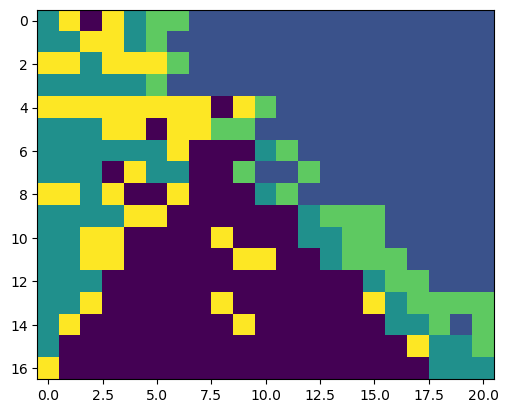

In [ ]:
plt.imshow(objectNN.clusters.reshape(17,21))

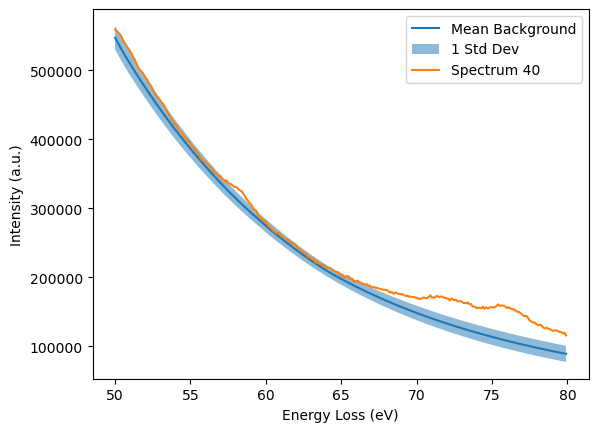

[np.float64(50.00000074505806), np.float64(79.90000119060278), np.float64(0.0), np.float64(1.006346970796585)]


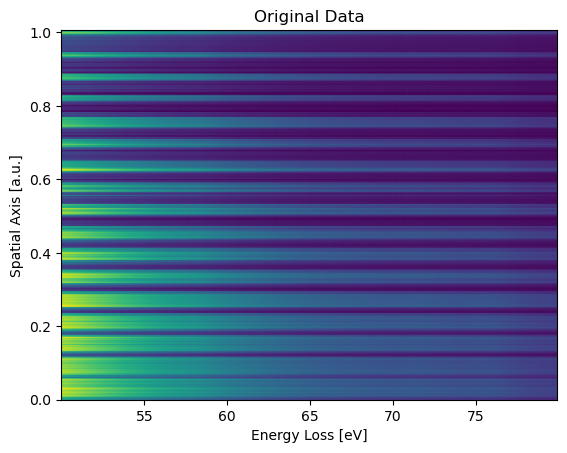

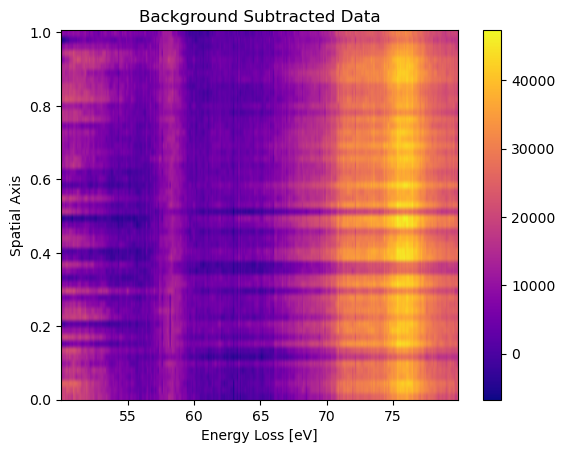

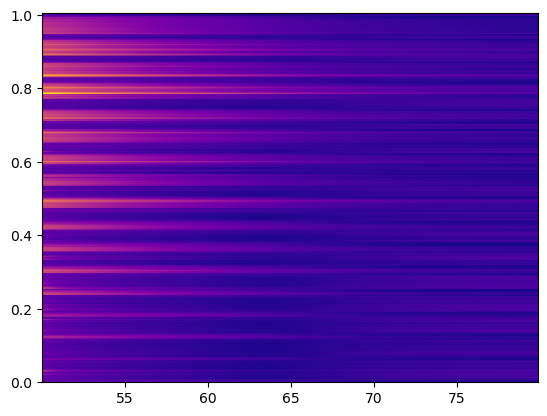

In [ ]:
# print(objectNN.background[3])
# objectNN.background,0)
# plt.imshow(objectNN.background[5], aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.title('Singular Background Prediction')
# plt.show()
# print(objectNN.background.shape)
bgmean = np.mean(objectNN.background[:6], axis=0)
bgstd = np.std(objectNN.background[:6], axis=0)

# plt.plot(objectNN.background[:,40,:].T)
# plt.title('Background Predictions for a Single Spectrum')
# plt.plot(objectNN.intensity_data.T, alpha=0.5)
# # plt.colorbar()
# plt.plot(objectNN.background[0])
# print(objectNN.background[1]-objectNN.background[0])
# plt.imshow(bgmean, aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.show()
# tii = objectNN.total_integrated_intensity
# frac = 0.7
# plt.plot((tii-frac*min(tii))/(max(tii)-min(tii)*frac)*len(objectNN.energy_axis), range(len(objectNN.spatial_axis)), color='red')
# plt.imshow(bgstd, aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.show()


show_spectrum = 45
plt.plot(objectNN.energy_axis, bgmean[show_spectrum], label='Mean Background')
plt.fill_between(objectNN.energy_axis, bgmean[show_spectrum]-bgstd[show_spectrum], bgmean[show_spectrum]+bgstd[show_spectrum], alpha=0.5, label='1 Std Dev')
plt.plot(objectNN.energy_axis, objectNN.intensity_data[show_spectrum], label='Spectrum 40')
plt.xlabel('Energy Loss (eV)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.show()

extentslice = [objectNN.energy_axis[0], objectNN.energy_axis[-1], objectNN.spatial_axis[0], objectNN.spatial_axis[-1]]
print(extentslice)

plt.imshow(objectNN.intensity_data, extent= extentslice, aspect='auto', cmap='viridis')
# plt.colorbar('Intensity [a.u.]')
plt.title('Original Data')
plt.xlabel('Energy Loss [eV]')
plt.ylabel('Spatial Axis [a.u.]')
plt.show()
# zscore = (objectNN.intensity_data - bgmean) / bgstd
# zscore_masked = np.where(zscore >= 1, zscore, 0)
# plt.imshow(zscore_masked, extent=[objectNN.energy_axis[0], objectNN.energy_axis[-1], objectNN.spatial_axis[0], objectNN.spatial_axis[-1]], aspect='auto', cmap='plasma')
plt.imshow(((objectNN.intensity_data - bgmean))[objectNN.clusters == 2], extent=extentslice, aspect='auto', cmap='plasma')
plt.colorbar()
plt.title('Background Subtracted Data')
plt.xlabel('Energy Loss [eV]')
plt.ylabel('Spatial Axis')
plt.show()

plt.imshow(bgstd, extent=extentslice, aspect='auto', cmap='plasma')

In [ ]:
intensity_no_background = objectNN.intensity_data - bgmean



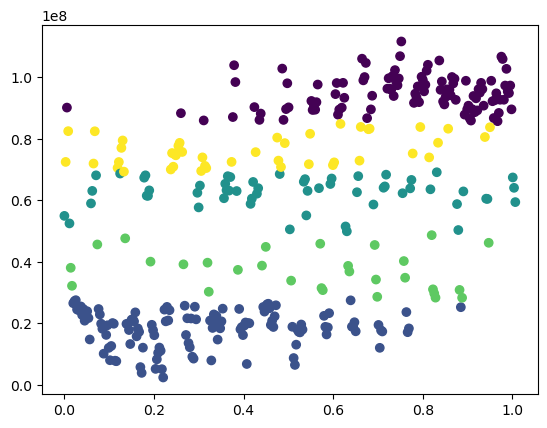

In [ ]:
plt.scatter(objectNN.spatial_axis,(objectNN.total_integrated_intensity), c=objectNN.clusters, cmap='viridis')

[2 4 0 4 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 4 4 2 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 4 2 4 4 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 0 4 3 1 1 1 1 1 1 1 1 1 1 2 2 2 4 4 0
 4 4 3 3 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 4 0 0 0 2 3 1 1 1 1 1 1 1 1 1 2
 2 2 0 4 2 2 0 0 3 1 1 3 1 1 1 1 1 1 1 1 4 4 2 4 0 0 4 0 0 0 2 3 1 1 1 1 1
 1 1 1 1 2 2 2 2 4 4 0 0 0 0 0 0 2 3 3 3 1 1 1 1 1 2 2 4 4 0 0 0 0 4 0 0 0
 2 2 3 3 1 1 1 1 1 2 2 4 4 0 0 0 0 0 4 4 0 0 2 3 3 3 1 1 1 1 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 2 3 3 1 1 1 2 2 4 0 0 0 0 0 4 0 0 0 0 0 0 4 2 3 3 3 3 2 4
 0 0 0 0 0 0 0 4 0 0 0 0 0 0 2 2 3 1 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 2 2 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2]
[2 4 0 4 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 4 4 2 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 4 2 4 4 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 0 4 3 1 1 1 1 1 1 1 1 1 1 2 2 2 4 4 0
 4 4 3 3 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 4 0 0 0

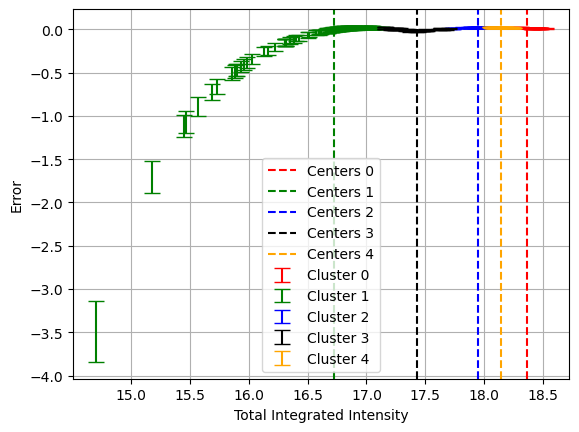

In [ ]:
errors = []
errorsstdev = []
for i in range(objectNN.intensity_data.shape[0]):
    difference = objectNN.intensity_data[i][:188] - bgmean[i][:188]
    bg_uncertainty  =  bgstd[i][:188]

    # plt.plot(difference)
    tii_difference = np.sum(difference)
    tii_intensity = np.sum(objectNN.intensity_data[i])
    error = tii_difference / tii_intensity
    errorstdev = np.sqrt(np.sum(bg_uncertainty**2)) / tii_intensity
    errors.append(error)
    errorsstdev.append(errorstdev)


colors = ['red', 'green', 'blue', 'black', 'orange']
clusters = np.array(objectNN.clusters)  # make sure it's a NumPy array for boolean indexing
x = np.array(np.log(objectNN.total_integrated_intensity))
y = np.array(errors)
yerr = np.array(errorsstdev)
print(clusters)
# plt.figure(figsize=(10, 6))
for cluster_id in range(5):
    mask = clusters == cluster_id
    print(clusters)
    print(x,y, yerr)

    plt.errorbar(x[mask], y[mask], yerr = yerr[mask], fmt ='none',
                 color=colors[cluster_id], capsize=6, 
                 label=f'Cluster {cluster_id}')
    plt.axvline(x=np.log(objectNN.clustered_spectra_centers[cluster_id]), color=colors[cluster_id], 
                linestyle='--', label=f'Centers {cluster_id}')


plt.grid()
plt.ylabel('Error')

plt.xlabel('Total Integrated Intensity')

plt.legend()
plt.show()
# plt.hlines(x=objectNN.clustered_spectra_centers, ymin = -1, ymax = 1, color='red', linestyle='-')

In [ ]:
from ipywidgets import interact, FloatSlider
from IPython.display import clear_output

import numpy as np

import matplotlib.pyplot as plt

def plot_integrated_intensity(energy_start, energy_stop):
    clear_output(wait=True)
    # Find indices in energy_axis for the selected range
    idx_start = np.searchsorted(objectNN.energy_axis, energy_start, side='left')
    idx_stop = np.searchsorted(objectNN.energy_axis, energy_stop, side='right')
    # Integrate background-subtracted intensity in the selected range for each spectrum
    integrated = np.sum(intensity_no_background[:, idx_start:idx_stop], axis=1)
    integrated_error = np.sum(bgstd[:, idx_start:idx_stop], axis=1)
    plt.figure(figsize=(8,4))

    dispersion = objectNN.spatial_axis[1] - objectNN.spatial_axis[0]
    plt.imshow(integrated.reshape(17,21)/integrated_error.reshape(17,21), extent = [0, 21*dispersion, 0 , 17*dispersion], cmap='plasma')

    plt.xlabel('Spatial Axis $x$ [µm]')
    plt.ylabel('Spatial Axis $y$ [µm]')
    plt.title(f'Integrated Intensity from {energy_start:.2f} to {energy_stop:.2f} eV')
    plt.colorbar(label='Integrated Intensity [a.u.]')
    plt.show()

energy_min = float(objectNN.energy_axis[0])
energy_max = float(objectNN.energy_axis[-1])

interact(
    plot_integrated_intensity,
    energy_start=FloatSlider(min=energy_min, max=energy_max, step=0.1, value=energy_min, description='Start (eV)'),
    energy_stop=FloatSlider(min=energy_min, max=energy_max, step=0.1, value=energy_max, description='Stop (eV)')
)

interactive(children=(FloatSlider(value=50.00000074505806, description='Start (eV)', max=79.90000119060278, mi…

<function __main__.plot_integrated_intensity(energy_start, energy_stop)>